# **L2 norm varying the number of modes, for the $\mu$ reference and worst reconstructed**

Per la norma L2 adopero la mesh attuale, senza l'ausilio del piano 2D. utilizzo il set di parametri di riferimento: 
$\mu_{\text{reference}} = \{3\cdot 10^{19}, 2.208, 0.24, 1\cdot 10^{-3},1\cdot 10^{-5}, 2000\}^T$ e quelli peggio ricostruiti dal POD-greedy. 

Poi passo a calcoalre la norma L2 su di un test set di 100 parametri. 

In [1]:
# Pulizia
from IPython import get_ipython
get_ipython().magic('clear')
get_ipython().magic('reset -f')

# Import libraries:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.sparse as sparse
import h5py
import sys
import os
import json

# Import user-defined libraries:
sys.path.append(os.path.abspath('/Users/martina/Library/CloudStorage/OneDrive-PolitecnicodiMilano/PhD/Git/rom-cylinder_DEIM-POD/offline-online stages/fit White/0. full order'))
from FreeFEM import FFmatrix_fread, FFvector_fread
from solver_class import FiniteElementCylinderSolver, ReducedBasisCylinderSolver

/var/folders/gs/p2p59ns16hlgpqv_027665gm0000gn/T/ipykernel_2587/3218235193.py:3: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  get_ipython().magic('clear')
/var/folders/gs/p2p59ns16hlgpqv_027665gm0000gn/T/ipykernel_2587/3218235193.py:4: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  get_ipython().magic('reset -f')


In [2]:
# Load coordinates:
coordinates_Px = FFvector_fread('mesh_utilities/vv_cc_Px.btxt')
coordinates_Pq = FFvector_fread('mesh_utilities/vv_cc_Pq.btxt')

# Identify degrees of freedom of the Px and Pq spaces:
sFO_Px = coordinates_Px.shape[0]
sFO_Pq = coordinates_Pq.shape[0]
print(rf'Degree of freedom = {sFO_Px}')

# Define vector of all Px indeces:
mask_all = np.arange(sFO_Px, dtype=int)

# Identify indeces of the top, bottom and middle boundaries in Px:
mask_inf_bc = mask_all[np.isclose([coordinates_Px[ii, 1] for ii in range(sFO_Px)], np.zeros((sFO_Px)))]
mask_sup_bc = mask_all[np.isclose([coordinates_Px[ii, 1] for ii in range(sFO_Px)], np.ones((sFO_Px)))]
mask_mid_bc = mask_all[np.isclose([coordinates_Px[ii, 0] for ii in range(sFO_Px)], np.zeros((sFO_Px)))]
mask_ext_bc = mask_all[np.isclose([coordinates_Px[ii, 0] for ii in range(sFO_Px)], np.ones((sFO_Px)))]

# Identify indeces of the Dirichlet b.c. for the temperature and concentration field:
mask_bc_T = np.fromiter(set(mask_sup_bc), int)
mask_bc_C = np.fromiter(set(mask_sup_bc) | set(mask_ext_bc) | set(mask_inf_bc), int)

# Identify indeces of the interior for the temperature and concentration field:
mask_in_T = [ii for ii in mask_all if ii not in mask_bc_T]
mask_in_C = [ii for ii in mask_all if ii not in mask_bc_C]

# Import mass matrices on the Px and on the Pq space:
mass_Px = FFmatrix_fread('mesh_utilities/ww_mm_Px.btxt')
mass_Pq = FFmatrix_fread('mesh_utilities/ww_mm_Pq.btxt')
mass_Pm = FFmatrix_fread('mesh_utilities/ww_uu_Px_Pq.btxt')

# Extract integration weights and diagonal matrix with their inverse:
weights_Pq = mass_Pq.diagonal()
project_Pq = sparse.diags(np.reciprocal(weights_Pq))

# Import map from Px to Pq and to the dx, dy, dz derivative evaluated in Pq:
PxtoPquu_C = project_Pq.dot(FFmatrix_fread('mesh_utilities/ww_uu_Px_Pq.btxt')[:, mask_in_C])
PxtoPqdx_C = project_Pq.dot(FFmatrix_fread('mesh_utilities/ww_dx_Px_Pq.btxt')[:, mask_in_C])
PxtoPqdy_C = project_Pq.dot(FFmatrix_fread('mesh_utilities/ww_dy_Px_Pq.btxt')[:, mask_in_C])

# Define weights for the integration in polar coordinates:
polar_weights_Pq = np.multiply(coordinates_Pq[:, 0], weights_Pq)

# Compute volume of the domain:
volume = np.dot(np.ones(sFO_Pq), polar_weights_Pq)

# Assemble mass matrix and projected forcing term:
forc_C = PxtoPquu_C.T.dot(polar_weights_Pq[:, None])
mass_C = PxtoPquu_C.T.dot(PxtoPquu_C.multiply(polar_weights_Pq[:, None]))
inte_C = PxtoPquu_C.T.dot(polar_weights_Pq) / volume

Degree of freedom = 10201


In [11]:
#DA FARE UNA SOLA VOLTA PER PRODURRE IL FILE
with open("data/worst reconstructed parameters.json", "r") as json_file:
    parameters = json.load(json_file)
cur_FR = parameters["FISSION_RATE"]  
cur_BC = parameters["T_BC"]  
cur_LL = parameters["LENGTH"]  
cur_RR = parameters["RADIUS"]  
cur_FY = parameters["FISSION_YIELD"]  
cur_K  = parameters["FUEL_THERMAL_CONDUCTIVITY"]  
cur_dt= 1.00E+04

# #Assemble full order model and compute full order solution associated with the current parameter selection:
solver_FO = FiniteElementCylinderSolver()
solver_FO.assemble(RADIUS=cur_RR, LENGTH=cur_LL, F_RATE=cur_FR, F_YIELD=cur_FY, T_BC=cur_BC, KTH=cur_K , dt=cur_dt)
solution_FO = solver_FO.solve(n_steps=1000, verbose=False) #dimensione (mask_in_C, tempi)
average_FO =  inte_C @ solution_FO[:,1000]
np.savetxt('data/Fullorder_Cfield(WorstReconstructedParameters).csv', solution_FO[:, :], delimiter=',', fmt='%d')

# solver_RB = ReducedBasisCylinderSolver(basis) 
# solver_RB.assemble(RADIUS=cur_RR, LENGTH=cur_LL, F_RATE=cur_FR, F_YIELD=cur_FY, T_BC=cur_BC, KTH=cur_K , dt=cur_dt)
# solution_RB= solver_RB.solve(n_steps=1000, error_bound=False)

In [ ]:
#solution_FO = np.loadtxt('FOM_field (worst reconstructed parameters).csv', delimiter=',')
# print(inte_C @ solution_FO[:,1000])
# print(average_FO)
# print(solution_FO.shape)

7.36639972241257e+24
7.36639972241257e+24
(9900, 1001)


## **Reference parameters**

In [3]:
# Lettura dei parametri di riferimento dal file JSON
with open("data/Reference_parameters.json", "r") as json_file:
    parameters = json.load(json_file)
FISSION_ENERGY = parameters["FISSION_ENERGY"] 
FISSION_RATE = parameters["FISSION_RATE"]  
T_BC = parameters["T_BC"]  
LENGTH = parameters["LENGTH"]  
RADIUS = parameters["RADIUS"]  
FISSION_YIELD = parameters["FISSION_YIELD"]  
FUEL_THERMAL_CONDUCTIVITY  = parameters["FUEL_THERMAL_CONDUCTIVITY"]  
TIME_DELTA = 1.00E+04
SOURCE_C = FISSION_RATE * FISSION_YIELD         #[atm / (m^3 s)]
GAMMA_T = (FISSION_RATE * FISSION_ENERGY * LENGTH**2)/(FUEL_THERMAL_CONDUCTIVITY)

solution_FO = np.loadtxt('data/Fullorder_Cfield.csv', delimiter=',')  # Soluzione FOM
MM_FO = np.load('model_files/XX_FO.npy', allow_pickle=True)[0]  # Matrice per norma L2

with h5py.File('matrici_RB.h5', 'r') as hf:
    ZZ_CO = hf['ZZ_CO'][:]
    II_CO = hf['II_CO'][:]
    basis = hf['basis'][:]

TT = T_BC + GAMMA_T * (1 - ZZ_CO**2) / 2
WW = 7.60E-10 * np.exp(- 4.86E-19 / (TT * 1.380649E-23)) +\
     5.64E-25 * np.exp(- 1.91E-19 / (TT * 1.380649E-23)) * np.sqrt(FISSION_RATE) +\
     8.00E-40 * FISSION_RATE
CC_CO = np.hstack((II_CO @ WW / RADIUS**2, II_CO @ WW / LENGTH**2))

# Iterazione sulle dimensioni delle basi ridotte
errors_L2 = []
dimensions = []
max_dim = max(basis[1].shape)
print(max_dim)

for dim in range(1, max_dim+1):  # Da 1 a 57
    # Riduzione della base
    with h5py.File('matrici_RB.h5', 'r') as hf:
        MM_RB = hf['MM_RB'][:dim, :dim]
        FF_RB = hf['FF_RB'][:dim]
        KK_RB = hf['KK_RB'][:, :dim, :dim]
        AA_RB = hf['AA_RB'][:dim]
        basis = hf['basis'][:, :dim]        #9900xN_epsilon. 9900 = mask_in_C
    
    # Inizializzazione della soluzione ridotta
    old_sol_RB = np.zeros((dim, 1))
    
    # Proiezione delle matrici nello spazio ridotto
    SS_RB = np.tensordot(CC_CO, KK_RB, axes=[0, 0])
    QQ_RB = SOURCE_C * FF_RB
    LHS_RB_static = MM_RB + TIME_DELTA * SS_RB #matrice + matrice * scalare. Avendo il termine MM_RB al lhs è forward euler, se invece fosse nel RHS sarebbe Backward. 
    RHS_RB_static = TIME_DELTA * QQ_RB         #vettore per scalare

    # Calcolo della soluzione ridotta
    LHS_RB_reduced = MM_RB + TIME_DELTA * SS_RB
    RHS_RB_reduced = TIME_DELTA * QQ_RB
    for _ in range(1000):
        old_sol_RB = np.linalg.solve(LHS_RB_static, RHS_RB_static + MM_RB.dot(old_sol_RB))

    # Ricostruzione nello spazio completo
    ROM = np.dot(basis, old_sol_RB[:,0])
    
    # Calcolo dell'errore in norma L2
    difference = solution_FO[mask_in_C, 1000] - ROM
    L2_norm = np.sqrt(MM_FO.dot(difference).dot(difference))
    reference_norm = np.sqrt(MM_FO.dot(solution_FO[mask_in_C, 1000]).dot(solution_FO[mask_in_C, 1000]))
    L2_normalized = L2_norm / reference_norm
    
    # Salva i risultati
    errors_L2.append(L2_normalized)
    dimensions.append(dim)
    print(f"Dim: {dim}, L2 normalized error: {L2_normalized}")

# Risultati finali
print("Dimensioni delle basi:", dimensions)
print("Errori normalizzati in norma L2:", errors_L2)

101
Dim: 1, L2 normalized error: 0.017440008265774683
Dim: 2, L2 normalized error: 0.003006508033111591
Dim: 3, L2 normalized error: 0.0009165014077605143
Dim: 4, L2 normalized error: 0.0003352474636168065
Dim: 5, L2 normalized error: 0.0001288224477918421
Dim: 6, L2 normalized error: 7.282075836547717e-05
Dim: 7, L2 normalized error: 5.005410596868101e-05
Dim: 8, L2 normalized error: 6.479734875927071e-05
Dim: 9, L2 normalized error: 9.664967180231452e-05
Dim: 10, L2 normalized error: 9.527419851425089e-05
Dim: 11, L2 normalized error: 0.00024319829091311188
Dim: 12, L2 normalized error: 0.00020452784511124217
Dim: 13, L2 normalized error: 0.00022549383392688794
Dim: 14, L2 normalized error: 0.00029972315753715086
Dim: 15, L2 normalized error: 0.0002991345995724503
Dim: 16, L2 normalized error: 0.00030071278534182593
Dim: 17, L2 normalized error: 0.00030706720783849436
Dim: 18, L2 normalized error: 0.0003066428861816672
Dim: 19, L2 normalized error: 0.0003066795723239993
Dim: 20, L2 n

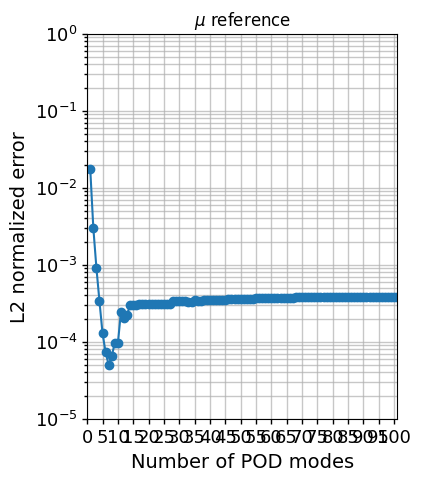

In [4]:
fig, (ax1) = plt.subplots(1, figsize=(4,5))
ax1.set_yscale('log')
ax1.plot(dimensions,errors_L2,  '-o')
ax1.tick_params(axis="y", which='both',labelsize=13,  width=1)
ax1.tick_params(axis='x', labelsize=13,  width=1)
ax1.set_xlabel('Number of POD modes',fontsize=14)
ax1.set_ylabel('L2 normalized error',fontsize=14)
#ax1.axvspan(1, NN, color='gray', alpha=0.2)
xticks = np.arange(0, max_dim, 5)  
ax1.set_xticks(xticks)
ax1.set_xlim([0, max_dim])
ax1.set_ylim([1e-5, 1])
ax1.set_title(rf'$\mu$ reference')
ax1.grid(visible=True, which='both', linewidth=1, alpha=0.7)
#plt.savefig(os.path.join('plot/Missing energy.pdf'), bbox_inches='tight')

## **Worst reconstructed parameters**

In [12]:
# Lettura dei parametri di riferimento dal file JSON
#with open("../0. full order/data/Reference_parameters.json", "r") as json_file:
with open("data/worst reconstructed parameters.json", "r") as json_file:
    parameters = json.load(json_file)
FISSION_ENERGY = parameters["FISSION_ENERGY"] 
FISSION_RATE = parameters["FISSION_RATE"]  
T_BC = parameters["T_BC"]  
LENGTH = parameters["LENGTH"]  
RADIUS = parameters["RADIUS"]  
FISSION_YIELD = parameters["FISSION_YIELD"]  
FUEL_THERMAL_CONDUCTIVITY  = parameters["FUEL_THERMAL_CONDUCTIVITY"]  
TIME_DELTA = 1.00E+04
SOURCE_C = FISSION_RATE * FISSION_YIELD         #[atm / (m^3 s)]
GAMMA_T = (FISSION_RATE * FISSION_ENERGY * LENGTH**2)/(FUEL_THERMAL_CONDUCTIVITY)

solution_FO = np.loadtxt('data/Fullorder_Cfield(WorstReconstructedParameters).csv', delimiter=',')  # Soluzione FOM
MM_FO = np.load('model_files/XX_FO.npy', allow_pickle=True)[0]  # Matrice per norma L2

with h5py.File('matrici_RB.h5', 'r') as hf:
    # Accedi ai dataset e ricrea le matrici
    ZZ_CO = hf['ZZ_CO'][:]
    II_CO = hf['II_CO'][:]
    basis = hf['basis'][:]


TT = T_BC + GAMMA_T * (1 - ZZ_CO**2) / 2
WW = 7.60E-10 * np.exp(- 4.86E-19 / (TT * 1.380649E-23)) +\
     5.64E-25 * np.exp(- 1.91E-19 / (TT * 1.380649E-23)) * np.sqrt(FISSION_RATE) +\
     8.00E-40 * FISSION_RATE
CC_CO = np.hstack((II_CO @ WW / RADIUS**2, II_CO @ WW / LENGTH**2))

# Iterazione sulle dimensioni delle basi ridotte
errors_L2 = []
dimensions = []
max_dim = max(basis[1].shape)


for dim in range(1, max_dim+1):  # Da 1 a 57
    # Riduzione della base
    with h5py.File('matrici_RB.h5', 'r') as hf:
        MM_RB = hf['MM_RB'][:dim, :dim]
        FF_RB = hf['FF_RB'][:dim]
        KK_RB = hf['KK_RB'][:, :dim, :dim]
        AA_RB = hf['AA_RB'][:dim]
        basis = hf['basis'][:, :dim]
    

    # Inizializzazione della soluzione ridotta
    old_sol_RB = np.zeros((dim, 1))
    
    # Proiezione delle matrici nello spazio ridotto
    SS_RB = np.tensordot(CC_CO, KK_RB, axes=[0, 0])
    QQ_RB = SOURCE_C * FF_RB
    LHS_RB_static = MM_RB + TIME_DELTA * SS_RB #matrice + matrice * scalare. Avendo il termine MM_RB al lhs è forward euler, se invece fosse nel RHS sarebbe Backward. 
    RHS_RB_static = TIME_DELTA * QQ_RB         #vettore per scalare

    # Calcolo della soluzione ridotta
    LHS_RB_reduced = MM_RB + TIME_DELTA * SS_RB
    RHS_RB_reduced = TIME_DELTA * QQ_RB
    for _ in range(1000):
        old_sol_RB = np.linalg.solve(LHS_RB_static, RHS_RB_static + MM_RB.dot(old_sol_RB))

    # Ricostruzione nello spazio completo
    ROM = np.dot(basis, old_sol_RB[:,0])
    
    # Calcolo dell'errore in norma L2
    difference = solution_FO[:, 1000] - ROM
    L2_norm = np.sqrt(MM_FO.dot(difference).dot(difference))
    reference_norm = np.sqrt(MM_FO.dot(solution_FO[:, 1000]).dot(solution_FO[:, 1000]))
    L2_normalized = L2_norm / reference_norm
    
    # Salva i risultati
    errors_L2.append(L2_normalized)
    dimensions.append(dim)
    print(f"Dim: {dim}, L2 normalized error: {L2_normalized}")

# Risultati finali
print("Dimensioni delle basi:", dimensions)
print("Errori normalizzati in norma L2:", errors_L2)

Dim: 1, L2 normalized error: 0.46261706450162815
Dim: 2, L2 normalized error: 0.15759262024874862
Dim: 3, L2 normalized error: 0.12416518261783939
Dim: 4, L2 normalized error: 0.11340315930003181
Dim: 5, L2 normalized error: 0.11656777722895871
Dim: 6, L2 normalized error: 0.10264109126588288
Dim: 7, L2 normalized error: 0.10248119314294839
Dim: 8, L2 normalized error: 0.09574905884502519
Dim: 9, L2 normalized error: 0.09538762617079036
Dim: 10, L2 normalized error: 0.09150081088297968
Dim: 11, L2 normalized error: 0.08984769847645206
Dim: 12, L2 normalized error: 0.08574485150037736
Dim: 13, L2 normalized error: 0.08631766162432858
Dim: 14, L2 normalized error: 0.08587971298074909
Dim: 15, L2 normalized error: 0.08478105803158333
Dim: 16, L2 normalized error: 0.08595368021860363
Dim: 17, L2 normalized error: 0.08573568959483945
Dim: 18, L2 normalized error: 0.0609682315528232
Dim: 19, L2 normalized error: 0.0495421236724265
Dim: 20, L2 normalized error: 0.04770864305181748
Dim: 21, L2

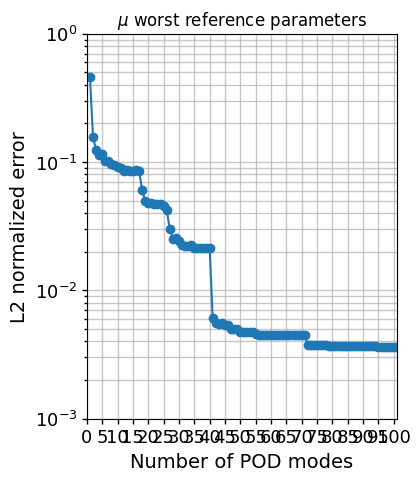

In [13]:
fig, (ax1) = plt.subplots(1, figsize=(4,5))
ax1.set_yscale('log')
ax1.plot(dimensions,errors_L2,  '-o')
ax1.tick_params(axis="y", which='both',labelsize=13,  width=1)
ax1.tick_params(axis='x', labelsize=13,  width=1)
ax1.set_xlabel('Number of POD modes',fontsize=14)
ax1.set_ylabel('L2 normalized error',fontsize=14)
#ax1.axvspan(1, NN, color='gray', alpha=0.2)
xticks = np.arange(0, max_dim, 5)  
ax1.set_xticks(xticks)
ax1.set_xlim([0, max_dim])
ax1.set_ylim([1e-3, 1])
ax1.set_title(rf'$\mu$ worst reference parameters')
ax1.grid(visible=True, which='both', linewidth=1, alpha=0.7)
#plt.savefig(os.path.join('plot/Missing energy.pdf'), bbox_inches='tight')

# **L2 norm in time**

In [14]:
# Pulizia
from IPython import get_ipython
get_ipython().magic('clear')
get_ipython().magic('reset -f')

# Import libraries:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import h5py
import sys
import os
import json

# Import user-defined libraries:
from FreeFEM import FFmatrix_fread, FFvector_fread
from solver_class import FiniteElementCylinderSolver, ReducedBasisCylinderSolver

/var/folders/gs/p2p59ns16hlgpqv_027665gm0000gn/T/ipykernel_5159/3605897851.py:3: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  get_ipython().magic('clear')
/var/folders/gs/p2p59ns16hlgpqv_027665gm0000gn/T/ipykernel_5159/3605897851.py:4: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  get_ipython().magic('reset -f')


In [3]:
FOM = np.loadtxt('data/Fullorder_Cfield(WorstReconstructedParameters).csv', delimiter=',')  # (102391 x 1001)
MM_FO = np.load('model_files/XX_FO.npy', allow_pickle=True)[0]  # Matrice per norma L2

with open("data/worst reconstructed parameters.json", "r") as json_file:
    parameters = json.load(json_file)
FISSION_ENERGY = parameters["FISSION_ENERGY"] 
FISSION_RATE = parameters["FISSION_RATE"]  
T_BC = parameters["T_BC"]  
LENGTH = parameters["LENGTH"]  
RADIUS = parameters["RADIUS"]  
FISSION_YIELD = parameters["FISSION_YIELD"]  
FUEL_THERMAL_CONDUCTIVITY  = parameters["FUEL_THERMAL_CONDUCTIVITY"]  
TIME_DELTA = 1.00E+04
SOURCE_C = FISSION_RATE * FISSION_YIELD         #[atm / (m^3 s)]
GAMMA_T = (FISSION_RATE * FISSION_ENERGY * LENGTH**2)/(FUEL_THERMAL_CONDUCTIVITY)

with h5py.File('matrici_RB.h5', 'r') as hf:
    ZZ_CO = hf['ZZ_CO'][:]
    II_CO = hf['II_CO'][:]
    basis = hf['basis'][:]

TT = T_BC + GAMMA_T * (1 - ZZ_CO**2) / 2
WW = 7.60E-10 * np.exp(- 4.86E-19 / (TT * 1.380649E-23)) +\
     5.64E-25 * np.exp(- 1.91E-19 / (TT * 1.380649E-23)) * np.sqrt(FISSION_RATE) +\
     8.00E-40 * FISSION_RATE
CC_CO = np.hstack((II_CO @ WW / RADIUS**2, II_CO @ WW / LENGTH**2))

# with h5py.File('matrici_RB.h5', 'r') as hf:
#         MM_RB = hf['MM_RB'][:dim, :dim]
#         FF_RB = hf['FF_RB'][:dim]
#         KK_RB = hf['KK_RB'][:, :dim, :dim]
#         AA_RB = hf['AA_RB'][:dim]
#         basis = hf['basis'][:, :dim]
        
max_dim = max(basis[1].shape)
num_time_steps = 1001
errors_L2 = np.zeros((max_dim, num_time_steps))

for dim in range(1, max_dim+1):
    # Riduzione della base
    with h5py.File('matrici_RB.h5', 'r') as hf:
        MM_RB = hf['MM_RB'][:dim, :dim]
        FF_RB = hf['FF_RB'][:dim]
        KK_RB = hf['KK_RB'][:, :dim, :dim]
        AA_RB = hf['AA_RB'][:dim]
        basis = hf['basis'][:, :dim]
    
    # Inizializzazione della soluzione ridotta
    old_sol_RB = np.zeros((dim, 1))

    SS_RB = np.tensordot(CC_CO, KK_RB, axes=[0, 0])
    QQ_RB = SOURCE_C * FF_RB
    LHS_RB_static = MM_RB + TIME_DELTA * SS_RB #matrice + matrice * scalare. Avendo il termine MM_RB al lhs è forward euler, se invece fosse nel RHS sarebbe Backward. 
    RHS_RB_static = TIME_DELTA * QQ_RB         #vettore per scalare

    LHS_RB_reduced = MM_RB + TIME_DELTA * SS_RB
    RHS_RB_reduced = TIME_DELTA * QQ_RB
    ROM = np.zeros((num_time_steps))
    for ii in range(1,num_time_steps):
        old_sol_RB = np.linalg.solve(LHS_RB_static, RHS_RB_static + MM_RB.dot(old_sol_RB))
        ROM = np.dot(basis, old_sol_RB[:,0])     #ricostruisco a quel specifico time step
        difference = FOM[:, ii] - ROM
        L2_norm = np.sqrt(MM_FO.dot(difference).dot(difference))
        reference_norm = np.sqrt(MM_FO.dot(FOM[:, ii]).dot(FOM[:, ii]))
        L2_normalized = L2_norm / reference_norm
        errors_L2[dim-1, ii] = L2_normalized 

        print(f"Dim: {dim}, time: {TIME_DELTA*ii}, L2 normalized error: {L2_normalized}")


Dim: 1, time: 10000.0, L2 normalized error: 0.6223992327905297
Dim: 1, time: 20000.0, L2 normalized error: 0.6183983860795812
Dim: 1, time: 30000.0, L2 normalized error: 0.615083065878924
Dim: 1, time: 40000.0, L2 normalized error: 0.6121989018792213
Dim: 1, time: 50000.0, L2 normalized error: 0.6096182879394251
Dim: 1, time: 60000.0, L2 normalized error: 0.6072664677685449
Dim: 1, time: 70000.0, L2 normalized error: 0.6050961899165321
Dim: 1, time: 80000.0, L2 normalized error: 0.603072081634489
Dim: 1, time: 90000.0, L2 normalized error: 0.6011716297217391
Dim: 1, time: 100000.0, L2 normalized error: 0.5993765213252902
Dim: 1, time: 110000.0, L2 normalized error: 0.5976725753954185
Dim: 1, time: 120000.0, L2 normalized error: 0.5960475904595746
Dim: 1, time: 130000.0, L2 normalized error: 0.5944944128255651
Dim: 1, time: 140000.0, L2 normalized error: 0.5930042278286433
Dim: 1, time: 150000.0, L2 normalized error: 0.5915701094321911
Dim: 1, time: 160000.0, L2 normalized error: 0.5901

In [4]:
np.savetxt("data/errors_L2_in_time.csv", errors_L2, delimiter=",")

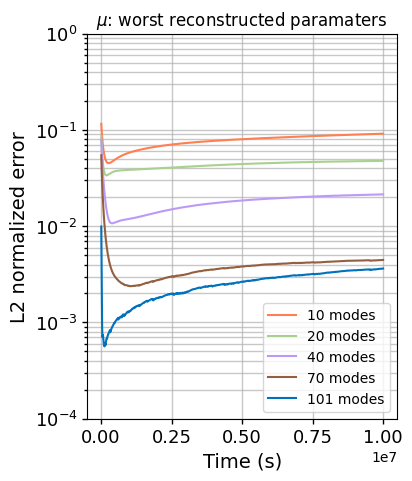

In [8]:
#prova = np.loadtxt('data/errors_L2_in_time.csv', delimiter=',')
time = np.linspace(0, 1e7, errors_L2.shape[1])[1:]

fig, (ax1) = plt.subplots(1, figsize=(4,5))
ax1.set_yscale('log')
ax1.plot(time,errors_L2[9,1:], color = '#FF7F50',label='10 modes')
ax1.plot(time,errors_L2[19,1:], color = '#A9D18E',label='20 modes')
ax1.plot(time,errors_L2[39,1:], color = '#BB9AF7',label='40 modes')
ax1.plot(time,errors_L2[69,1:], color = '#945f3e',label='70 modes')
ax1.plot(time,errors_L2[max_dim-1,1:], color = '#0072bd', label='101 modes' )
ax1.tick_params(axis="y", which='both',labelsize=13,  width=1)
ax1.tick_params(axis='x', labelsize=13,  width=1)
ax1.set_xlabel('Time (s)',fontsize=14)
ax1.set_ylabel('L2 normalized error',fontsize=14)
#ax1.axvspan(1, NN, color='gray', alpha=0.2)
#xticks = np.arange(0, 58, 5)  
#ax1.set_xticks(xticks)
#ax1.set_xlim([0, 57])
ax1.legend()
ax1.set_ylim([1e-4, 1])
ax1.set_title(rf'$\mu$: worst reconstructed paramaters')
ax1.grid(visible=True, which='both', linewidth=1, alpha=0.7)
plt.savefig('plot/L2error.pdf', bbox_inches='tight') 